# Text analysis of Trump's tweets confirms he writes only the (angrier) Android half

Text and sentiment analysis on Trump's tweets confirms that the tweets posted from the iPhone appear to come from his campaign, while his tweets from Android are the 'off-the-cuff' observations he's known for.



In [18]:
library(ggplot2)
theme_set(theme_bw())

I don't normally post about politics (I'm not particularly savvy about polling, which is where data science [has had the largest impact on politics](http://fivethirtyeight.com/)). But this weekend I saw a hypothesis about Donald Trump's twitter account that simply begged to be investigated with data:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Every non-hyperbolic tweet is from iPhone (his staff). <br><br>Every hyperbolic tweet is from Android (from him). <a href="https://t.co/GWr6D8h5ed">pic.twitter.com/GWr6D8h5ed</a></p>&mdash; Todd Vaziri (@tvaziri) <a href="https://twitter.com/tvaziri/status/762005541388378112">August 6, 2016</a></blockquote>
<script async src="http://platform.twitter.com/widgets.js" charset="utf-8"></script>

When Trump wishes the Olympic team good luck, he's tweeting from his iPhone. When he's insulting a rival, he's usually tweeting from an Android. Is this an artifact showing which tweets are Trump's own and which are by some handler?

Others have [explored Trump's timeline](http://www.cnet.com/news/trumps-tweets-android-for-nasty-iphone-for-nice/) and noticed this tends to hold up- and Trump himself [does indeed tweet from a Samsung Galaxy](http://www.theverge.com/2015/10/5/9453935/donald-trump-twitter-strategy). But how could we examine it quantitatively? I've been writing about text mining and [sentiment analysis](varianceexplained.org/r/yelp-sentiment/) recently, particularly during my development of the [tidytext R package](http://github.com/juliasilge/tidytext) with Julia Silge, and this is a great opportunity to apply it again.

My analysis, shown below, concludes that **the Android and iPhone tweets are clearly from different people**, posting during different times of day and using hashtags, links, and retweets in distinct ways. What's more, we can see that **the Android tweets are angrier and more negative**, while the iPhone tweets tend to be benign announcements and pictures. Overall I'd agree with [@tvaziri](https://twitter.com/tvaziri)'s analysis: this lets us tell the difference between the campaign's tweets (iPhone) and Trump's own (Android).

### The dataset

First we'll retrieve the content of Donald Trump's timeline using the `userTimeline` function in the [twitteR](https://cran.r-project.org/web/packages/twitteR) package:[^fullcode]

In [19]:
library(dplyr)
library(purrr)
#library(twitteR)

In [20]:
# if you want to follow along without setting up Twitter authentication,
# just use my dataset:
#load(url("http://varianceexplained.org/files/trump_tweets_df.rda"))
load("trump_tweets_df.rda")

We clean this data a bit, extracting the source application. (We're looking only at the iPhone and Android tweets- a much smaller number are from the web client or iPad).

In [21]:
library(tidyr)

tweets <- trump_tweets_df %>%
  select(id, statusSource, text, created) %>%
  extract(statusSource, "source", "Twitter for (.*?)<") %>%
  filter(source %in% c("iPhone", "Android"))

Overall, this includes `r sum(tweets$source == "iPhone")` tweets from iPhone, and `r sum(tweets$source == "Android")` tweets from Android.

One consideration is what time of day the tweets occur, which we'd expect to be a "signature" of their user. Here we can certainly spot a difference:

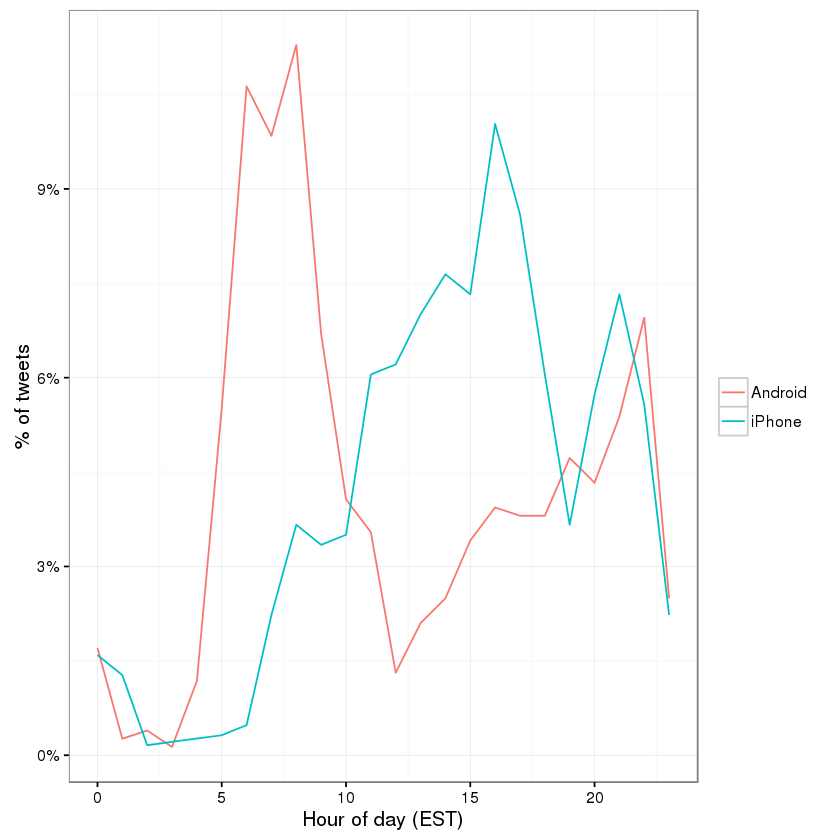

In [22]:
library(lubridate)
library(scales)

tweets %>%
  count(source, hour = hour(with_tz(created, "EST"))) %>%
  mutate(percent = n / sum(n)) %>%
  ggplot(aes(hour, percent, color = source)) +
  geom_line() +
  scale_y_continuous(labels = percent_format()) +
  labs(x = "Hour of day (EST)",
       y = "% of tweets",
       color = "")

Trump on the Android does a lot more tweeting in the morning, while the campaign posts from the iPhone more in the afternoon and early evening.

Another place we can spot a difference is in Trump's anachronistic behavior of "manually retweeting" people by copy-pasting their tweets, then surrounding them with quotation marks:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">&quot;<a href="https://twitter.com/trumplican2016">@trumplican2016</a>: <a href="https://twitter.com/realDonaldTrump">@realDonaldTrump</a> <a href="https://twitter.com/DavidWohl">@DavidWohl</a> stay the course mr trump your message is resonating with the PEOPLE&quot;</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/758512401629192192">July 28, 2016</a></blockquote>
<script async src="http://platform.twitter.com/widgets.js" charset="utf-8"></script>

Almost all of these quoted tweets are posted from the Android:

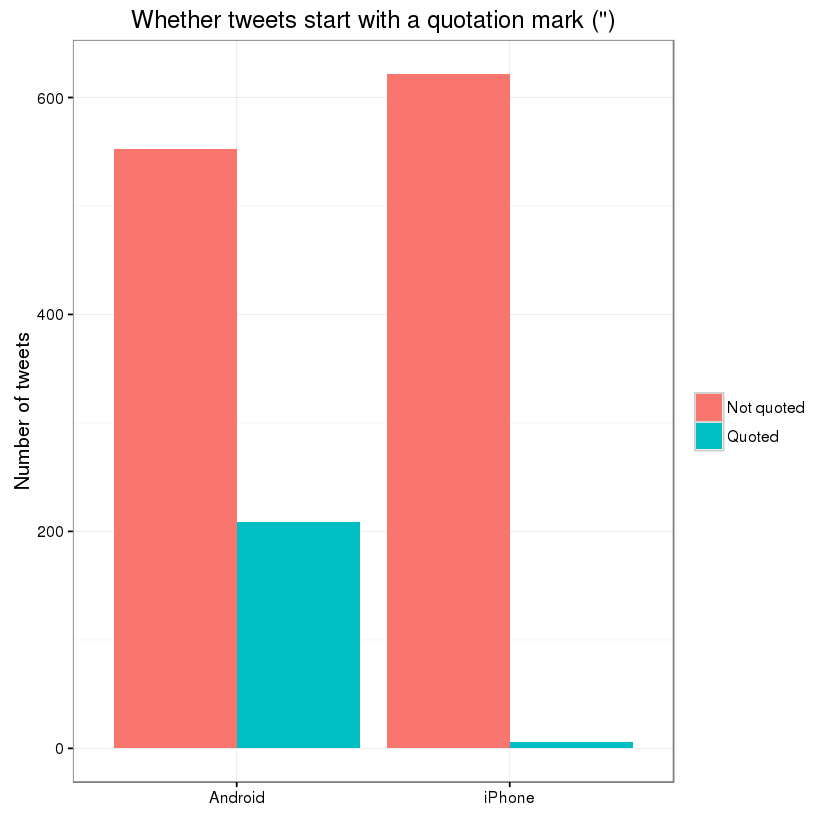

In [23]:
library(stringr)

tweets %>%
  count(source,
        quoted = ifelse(str_detect(text, '^"'), "Quoted", "Not quoted")) %>%
  ggplot(aes(source, n, fill = quoted)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "", y = "Number of tweets", fill = "") +
  ggtitle('Whether tweets start with a quotation mark (")')

In the remaining by-word analyses in this text, I'll filter these quoted tweets out (since they contain text from followers that may not be representative of Trump's own tweets).

Somewhere else we can see a difference involves sharing links or pictures in tweets.

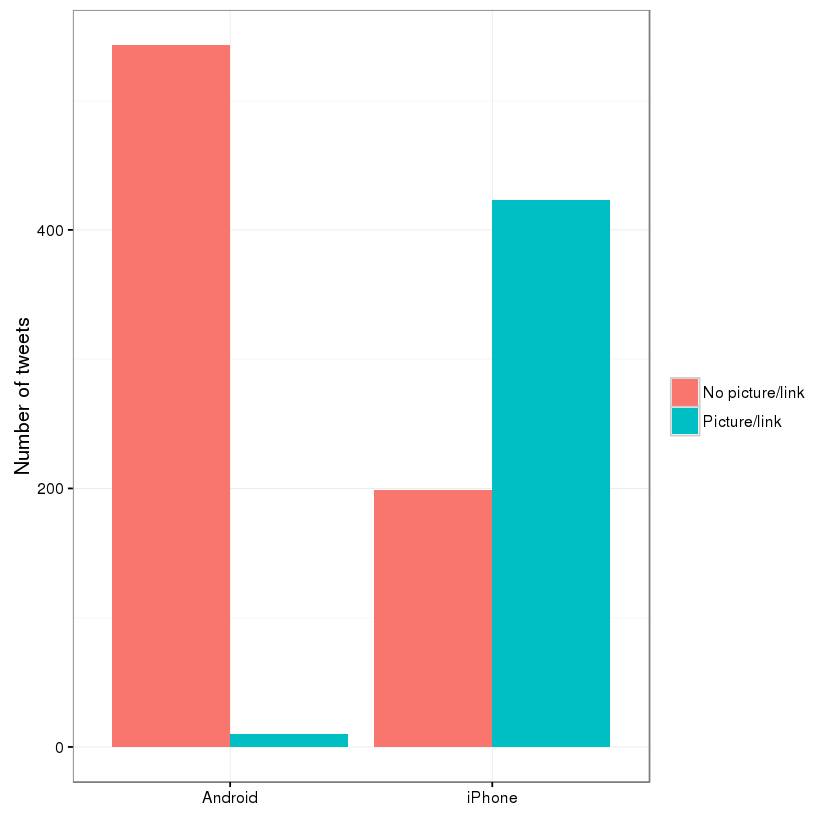

In [24]:
tweet_picture_counts <- tweets %>%
  filter(!str_detect(text, '^"')) %>%
  count(source,
        picture = ifelse(str_detect(text, "t.co"),
                         "Picture/link", "No picture/link"))

ggplot(tweet_picture_counts, aes(source, n, fill = picture)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "", y = "Number of tweets", fill = "")

In [25]:
spr <- tweet_picture_counts %>%
  spread(source, n) %>%
  mutate_each(funs(. / sum(.)), Android, iPhone)

rr <- spr$iPhone[2] / spr$Android[2]

It turns out tweets from the iPhone were **`r round(rr)` times as likely to contain either a picture or a link.** This also makes sense with our narrative: the iPhone (presumably run by the campaign) tends to write "announcement" tweets about events, like this:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Thank you Windham, New Hampshire! <a href="https://twitter.com/hashtag/TrumpPence16?src=hash">#TrumpPence16</a> <a href="https://twitter.com/hashtag/MAGA?src=hash">#MAGA</a> <a href="https://t.co/ZL4Q01Q49s">pic.twitter.com/ZL4Q01Q49s</a></p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/762110918721310721">August 7, 2016</a></blockquote>
<script async src="http://platform.twitter.com/widgets.js" charset="utf-8"></script>

While Android (Trump himself) tends to write picture-less tweets like:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The media is going crazy. They totally distort so many things on purpose. Crimea, nuclear, &quot;the baby&quot; and so much more. Very dishonest!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/762400869858115588">August 7, 2016</a></blockquote>
<script async src="http://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Comparison of words

Now that we're sure there's a difference between these two accounts, what can we say about the difference in the *content*? We'll use the [tidytext](https://cran.r-project.org/web/packages/tidytext) package that [Julia Silge](http://juliasilge.com/) and I developed.

We start by dividing into individual words using the `unnest_tokens` function (see [this vignette](https://cran.r-project.org/web/packages/tidytext/vignettes/tidytext.html) for more), and removing some common "stopwords"[^regex]:

In [26]:
library(tidytext)

reg <- "([^A-Za-z\\d#@']|'(?![A-Za-z\\d#@]))"
tweet_words <- tweets %>%
  filter(!str_detect(text, '^"')) %>%
  mutate(text = str_replace_all(text, "https://t.co/[A-Za-z\\d]+|&amp;", "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = reg) %>%
  filter(!word %in% stop_words$word,
         str_detect(word, "[a-z]"))

tweet_words

,id,source,created,word
1,676494179216805888,iPhone,2015-12-14 20:09:15,record
2,676494179216805888,iPhone,2015-12-14 20:09:15,health
3,676494179216805888,iPhone,2015-12-14 20:09:15,#makeamericagreatagain
4,676494179216805888,iPhone,2015-12-14 20:09:15,#trump2016
5,676509769562251264,iPhone,2015-12-14 21:11:12,accolade
6,676509769562251264,iPhone,2015-12-14 21:11:12,@trumpgolf
7,676509769562251264,iPhone,2015-12-14 21:11:12,highly
8,676509769562251264,iPhone,2015-12-14 21:11:12,respected
9,676509769562251264,iPhone,2015-12-14 21:11:12,golf
10,676509769562251264,iPhone,2015-12-14 21:11:12,odyssey


What were the most common words in Trump's tweets overall?

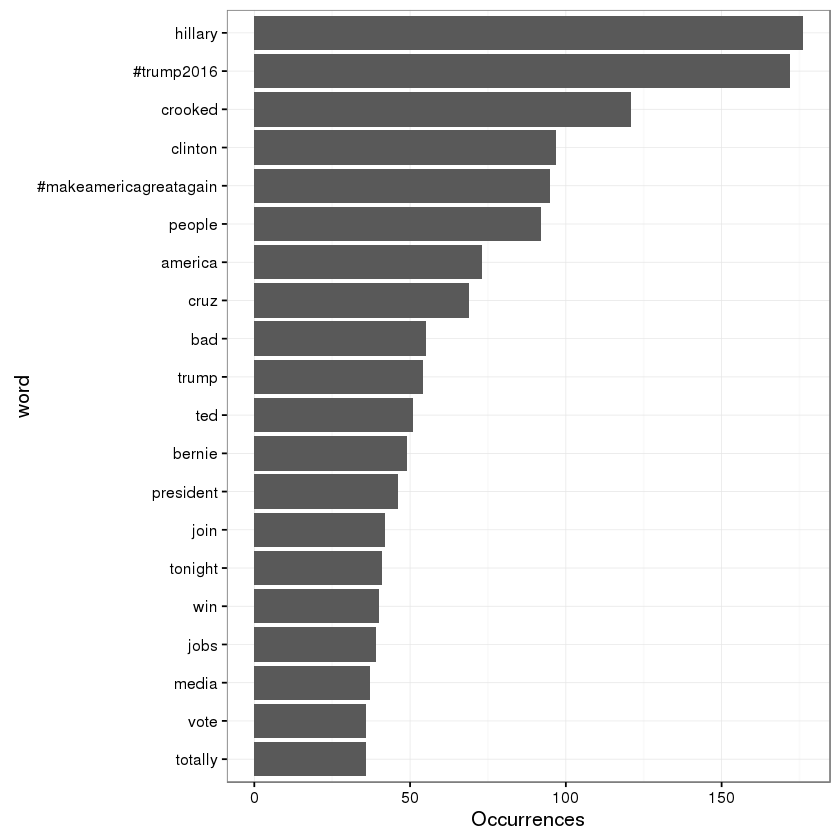

In [27]:
tweet_words %>%
  count(word, sort = TRUE) %>%
  head(20) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_bar(stat = "identity") +
  ylab("Occurrences") +
  coord_flip()

These should look familiar for anyone who has seen the feed. Now let's consider which words are most common from the Android relative to the iPhone, and vice versa. We'll use the simple measure of log odds ratio, calculated for each word as:[^plusone]

$$\log_2(\frac{\frac{\mbox{# in Android} + 1}{\mbox{Total Android} + 1}}
  {\frac{\mbox{# in iPhone} + 1}{\mbox{Total iPhone} + 1}})$$



In [28]:
android_iphone_ratios <- tweet_words %>%
  count(word, source) %>%
  filter(sum(n) >= 5) %>%
  spread(source, n, fill = 0) %>%
  ungroup() %>%
  mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
  mutate(logratio = log2(Android / iPhone)) %>%
  arrange(desc(logratio))

Which are the words most likely to be from Android and most likely from iPhone?

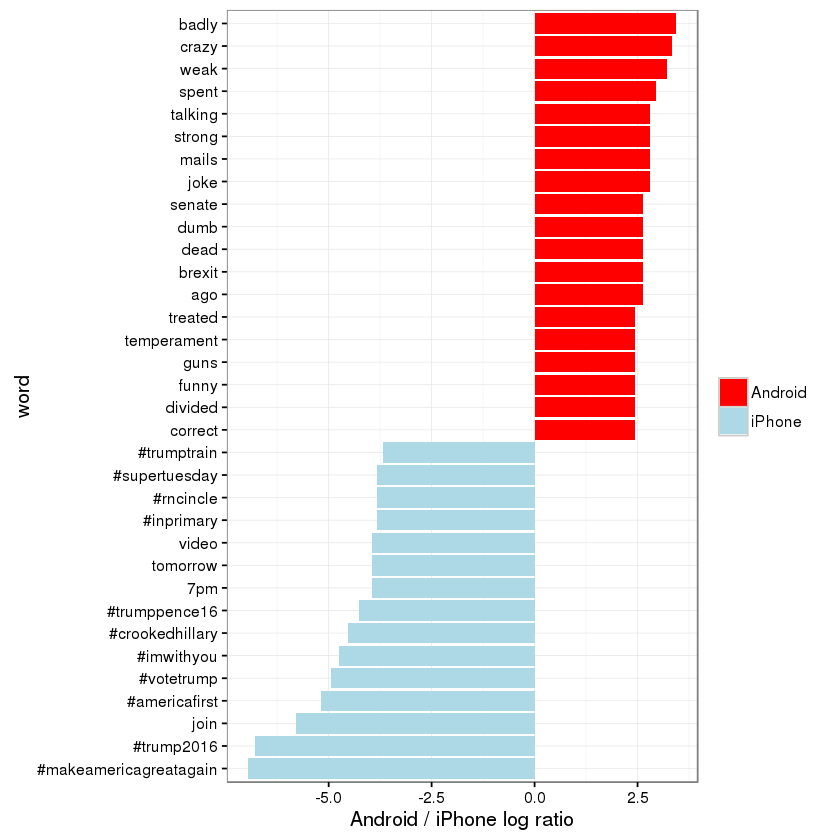

In [29]:
android_iphone_ratios %>%
  group_by(logratio > 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  ylab("Android / iPhone log ratio") +
  scale_fill_manual(name = "", labels = c("Android", "iPhone"),
                    values = c("red", "lightblue"))

A few observations:

* **Most hashtags come from the iPhone**. Indeed, almost no tweets from Trump's Android contained hashtags, with some rare exceptions like [this one](https://twitter.com/realDonaldTrump/status/753960134422900736). (This is true only because we filtered out the quoted "retweets", as Trump does sometimes quote tweets [like this](https://twitter.com/realDonaldTrump/status/731805331425218560) that contain hashtags).

* **Words like "join" and "tomorrow", and times like "7pm", also came only from the iPhone**. The iPhone is clearly responsible for event announcements like [this one](https://twitter.com/realDonaldTrump/status/743522630230228993) ("Join me in Houston, Texas tomorrow night at 7pm!")

* **A lot of "emotionally charged" words, like "badly", "crazy", "weak", and "dumb", were overwhelmingly more common on Android.** This supports the original hypothesis that this is the "angrier" or more hyperbolic account.

### Sentiment analysis: Trump's tweets are much more negative than his campaign's

Since we've observed a difference in sentiment between the Android and iPhone tweets, let's try quantifying it. We'll work with the [NRC Word-Emotion Association](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) lexicon, available from the tidytext package, which associates words with 10 sentiments: **positive**, **negative**, **anger**, **anticipation**, **disgust**, **fear**, **joy**, **sadness**, **surprise**, and **trust**.

In [30]:
nrc <- sentiments %>%
  filter(lexicon == "nrc") %>%
  dplyr::select(word, sentiment)

nrc

,word,sentiment
1,abacus,trust
2,abandon,fear
3,abandon,negative
4,abandon,sadness
5,abandoned,anger
6,abandoned,fear
7,abandoned,negative
8,abandoned,sadness
9,abandonment,anger
10,abandonment,fear


To measure the sentiment of the Android and iPhone tweets, we can count the number of words in each category:


In [31]:
sources <- tweet_words %>%
  group_by(source) %>%
  mutate(total_words = n()) %>%
  ungroup() %>%
  distinct(id, source, total_words)

by_source_sentiment <- tweet_words %>%
  inner_join(nrc, by = "word") %>%
  count(sentiment, id) %>%
  ungroup() %>%
  complete(sentiment, id, fill = list(n = 0)) %>%
  inner_join(sources) %>%
  group_by(source, sentiment, total_words) %>%
  summarize(words = sum(n)) %>%
  ungroup()

head(by_source_sentiment)

Joining by: "id"


,source,sentiment,total_words,words
1,Android,anger,4901,321
2,Android,anticipation,4901,256
3,Android,disgust,4901,207
4,Android,fear,4901,268
5,Android,joy,4901,199
6,Android,negative,4901,560


(For example, we see that `r by_source_sentiment$words[1]` of the `r by_source_sentiment$total_words[1]` words in the Android tweets were associated with "anger"). We then want to measure how much more likely the Android account is to use an emotionally-charged term relative to the iPhone account. Since this is count data, we can use a [Poisson test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/poisson.test.html) to measure the difference:

In [32]:
library(broom)

sentiment_differences <- by_source_sentiment %>%
  group_by(sentiment) %>%
  do(tidy(poisson.test(.$words, .$total_words)))

sentiment_differences

,sentiment,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
1,anger,1.49286282596596,321,2.19324246479133e-05,274.361933051525,1.23531615576069,1.80937092839328,Comparison of Poisson rates,two.sided
2,anticipation,1.16980397925435,256,0.119166830912859,239.646749685822,0.960495026250571,1.42756496959041,Comparison of Poisson rates,two.sided
3,disgust,1.67725921703334,207,1.77743389393102e-05,170.216382954416,1.31162383812564,2.15740470758367,Comparison of Poisson rates,two.sided
4,fear,1.56028021492212,268,1.88612914520052e-05,225.648691877071,1.26404941829309,1.9333855823642,Comparison of Poisson rates,two.sided
5,joy,1.00260543374194,199,1,198.772420884268,0.808935747360269,1.24445423055537,Comparison of Poisson rates,two.sided
6,negative,1.69284133536327,560,7.09448634076119e-13,459.136296127042,1.45869260997939,1.96871160054395,Comparison of Poisson rates,two.sided
7,positive,1.05875955570787,555,0.38205707545637,541.4448760425,0.930373153256449,1.20562453498296,Comparison of Poisson rates,two.sided
8,sadness,1.62004422254517,303,1.15049294426384e-06,251.965040557523,1.32602523226966,1.98651810579467,Comparison of Poisson rates,two.sided
9,surprise,1.167924913283,159,0.217448290023777,148.939335085114,0.908351704922708,1.50659273367198,Comparison of Poisson rates,two.sided
10,trust,1.12848247439377,369,0.147192891471779,350.511367531132,0.959747783891873,1.32849272794614,Comparison of Poisson rates,two.sided


And we can visualize it with a 95% confidence interval:


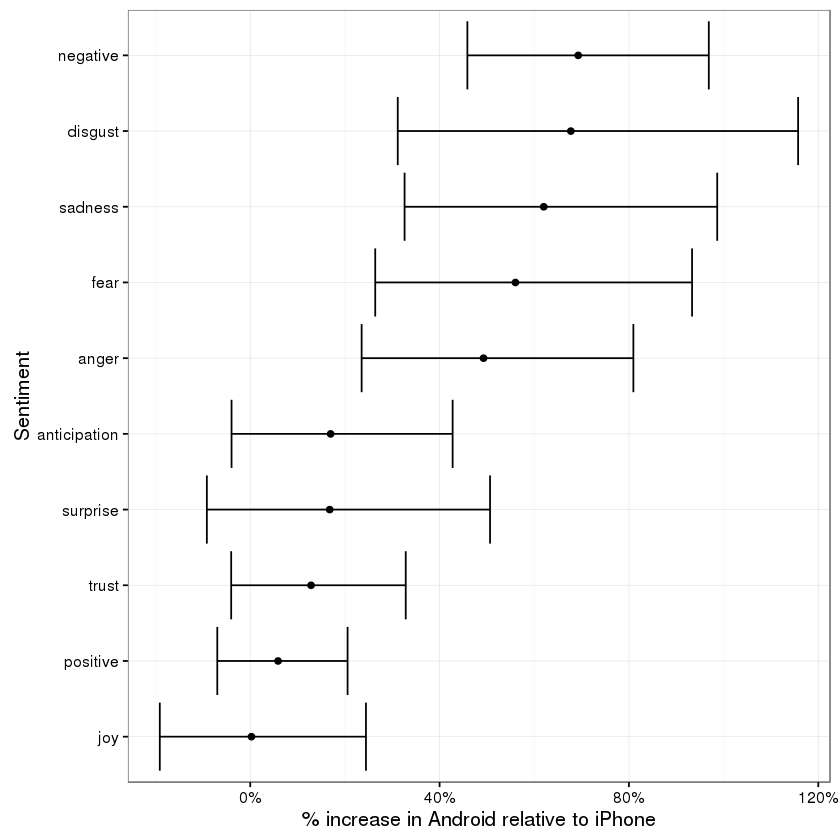

In [33]:
library(scales)

sentiment_differences %>%
  ungroup() %>%
  mutate(sentiment = reorder(sentiment, estimate)) %>%
  mutate_each(funs(. - 1), estimate, conf.low, conf.high) %>%
  ggplot(aes(estimate, sentiment)) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  scale_x_continuous(labels = percent_format()) +
  labs(x = "% increase in Android relative to iPhone",
       y = "Sentiment")

Thus, Trump's Android account uses about 40-80% more words related to **disgust**, **sadness**, **fear**, **anger**, and other "negative" sentiments than the iPhone account does. (The positive emotions weren't different to a statistically significant extent).

We're especially interested in which words drove this different in sentiment. Let's consider the words with the largest changes within each category:


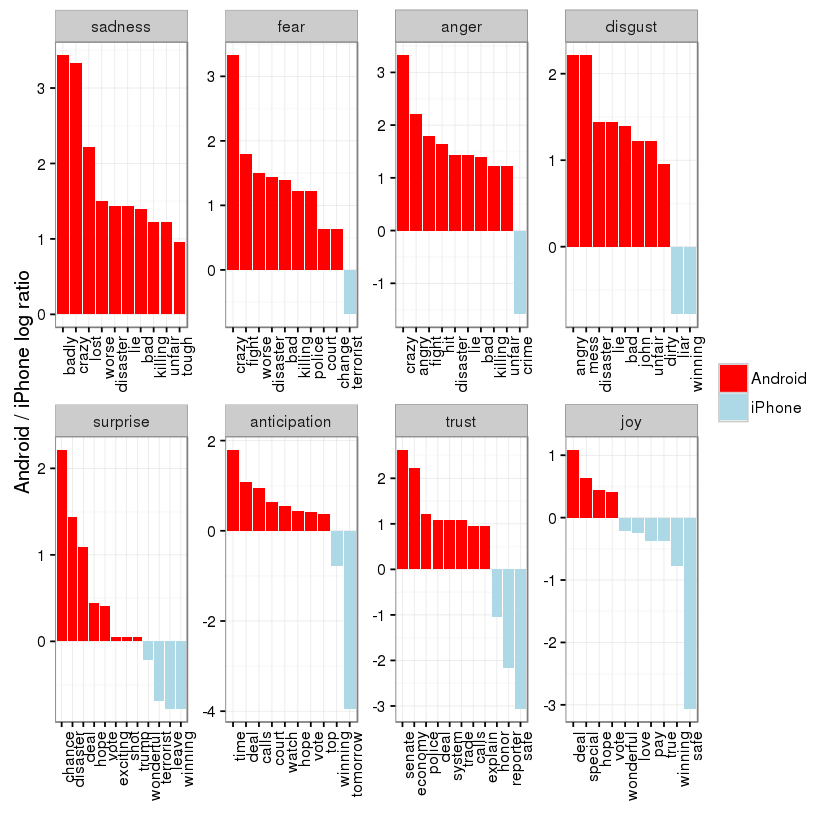

In [34]:
android_iphone_ratios %>%
  inner_join(nrc, by = "word") %>%
  filter(!sentiment %in% c("positive", "negative")) %>%
  mutate(sentiment = reorder(sentiment, -logratio),
         word = reorder(word, -logratio)) %>%
  group_by(sentiment) %>%
  top_n(10, abs(logratio)) %>%
  ungroup() %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  facet_wrap(~ sentiment, scales = "free", nrow = 2) +
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "", y = "Android / iPhone log ratio") +
  scale_fill_manual(name = "", labels = c("Android", "iPhone"),
                    values = c("red", "lightblue"))

This confirms that lots of words annotated as negative sentiments (with a few exceptions like "crime" and "terrorist") are more common in Trump's Android tweets than the campaign's iPhone tweets.

### Conclusion: the ghost in the political machine

I was fascinated by the recent [New Yorker article](http://www.newyorker.com/magazine/2016/07/25/donald-trumps-ghostwriter-tells-all) about Tony Schwartz, Trump's ghostwriter for The Art of the Deal. Of particular interest was how Schwartz imitated Trump's voice and philosophy:

> In his journal, Schwartz describes the process of trying to make Trump’s voice palatable in the book. It was kind of “a trick,” he writes, to mimic Trump’s blunt, staccato, no-apologies delivery while making him seem almost boyishly appealing.... Looking back at the text now, Schwartz says, “I created a character far more winning than Trump actually is.” 

Like any journalism, data journalism is ultimately about human interest, and there's one human I'm interested in: who is writing these iPhone tweets?

The majority of the tweets from the iPhone are fairly benign declarations. But consider cases like these, both posted from an iPhone:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Like the worthless <a href="https://twitter.com/NYDailyNews">@NYDailyNews</a>, looks like <a href="https://twitter.com/politico">@politico</a> will be going out of business. Bad reporting- no money, no cred!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/697404736211959808">February 10, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Failing <a href="https://twitter.com/nytimes">@NYTimes</a> will always take a good story about me and make it bad. Every article is unfair and biased. Very sad!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/733691591198703616">May 20, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

These tweets certainly sound like the Trump we all know. Maybe our above analysis isn't complete: maybe Trump has sometimes, however rarely, tweeted from an iPhone (perhaps dictating, or just using it when his own battery ran out). But what if our hypothesis is right, and these weren't authored by the candidate- just someone trying their best to sound like him?

Or what about tweets like this (also iPhone), which defend Trump's slogan- but doesn't really sound like something he'd write?

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Our country does not feel &#39;great already&#39; to the millions of wonderful people living in poverty, violence and despair.</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/758492727583576064">July 28, 2016</a></blockquote>
<script async src="http://platform.twitter.com/widgets.js" charset="utf-8"></script>

A lot has been written about Trump's mental state. But I'd really rather get inside the head of this anonymous staffer, whose job is to imitate Trump's unique cadence ("Very sad!"), or to put a positive spin on it, to millions of followers. Is he a true believer, or just a cog in a political machine, mixing whatever mainstream appeal he can into the @realDonaldTrump concoction? Like Tony Schwartz, will he one day regret his involvement?

[^fullcode]: To keep the post concise I don't show all of the code, especially code that generates figures. But you can find the full code [here](https://github.com/dgrtwo/dgrtwo.github.com/blob/master/_R/2016-08-09-trump-tweets.Rmd).
[^regex]: We had to use a custom regular expression for Twitter, since typical tokenizers would split the # off of hashtags and @ off of usernames. We also removed links and ampersands (`&amp;`) from the text.
[^plusone]: The "plus ones," called [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) are to avoid dividing by zero and to put [more trust in common words](http://varianceexplained.org/r/empirical_bayes_baseball/).
